In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import torch
import os
import numpy as np

* Load training hyper-parameters

In [2]:
import json
from utils import DictToClass

model_dir = 'runs/resnet20_cifar10_sgd/cosine_lr=1.00e-01_bs=128_wd=5.00e-04_corr-1.0_-1_cat[]_seed=1'
with open(os.path.join(model_dir, 'config.json'), 'r') as f:
    args = f.read()
args = json.loads(args)
args = DictToClass(args)

# device = torch.device(f'cuda:{args.gpu_id}' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0')

* Prepare training set (shffuled v.s. unshuffled)

In [3]:
from data import cifar_dataset
from utils import cycle_loader

train_set, test_set = cifar_dataset(data_name=args.data_name, root=args.data_dir, label_corruption=args.label_corruption, example_per_class=args.example_per_class, categories=args.categories)

train_loader_no_shuffle = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size_train, shuffle=False, num_workers=args.num_workers, pin_memory=args.pin_memory, drop_last=False)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size_train, shuffle=True, num_workers=args.num_workers,
    pin_memory=args.pin_memory, drop_last=True)
train_loader_cycle = cycle_loader(train_loader)

Files already downloaded and verified
Files already downloaded and verified


* Load pretrained neural network

In [4]:
from pytorchcv.model_provider import get_model as ptcv_get_model

net =  ptcv_get_model(args.arch, pretrained=False).to(device)
net.load_state_dict(torch.load(os.path.join(model_dir, 'state_dict.pt'), map_location=device))

loss_func = torch.nn.CrossEntropyLoss(reduction='none')

* Calculate true gradient

In [5]:
from utils import get_grads

true_gradient = 0.0
net.train()
for x, y in train_loader_no_shuffle:
    x, y = x.to(device), y.to(device)
    net.zero_grad()
    yhat = net(x)
    loss = loss_func(yhat, y)
    loss.mean().backward()
    curr_gradient = get_grads(net)
    true_gradient = true_gradient + curr_gradient * len(x)
true_gradient = true_gradient / len(train_loader_no_shuffle.dataset)

* Estimate a sequence of stochastic gradient noise

In [6]:
num_components = 300000 # number of coordinates used to estimate Hurst parameter 
len_of_sequence = 3000 # number of mini-batches to generate a stochastic sequence
tot_param = len(true_gradient)        
if tot_param < num_components:
    num_components = tot_param
fixed_dims = torch.randperm(tot_param)[:num_components]

stochastic_grads = []

net.train()
for j, (x, y) in enumerate(train_loader_cycle):
    if j == len_of_sequence:
        break
    x, y = x.to(device), y.to(device)
    net.zero_grad()
    yhat = net(x)
    loss = loss_func(yhat, y)
    loss.mean().backward()
    curr_gradient = get_grads(net)
    stochastic_grads.append(curr_gradient[fixed_dims])
stochastic_grads = torch.vstack(stochastic_grads)

stochastic_grads = stochastic_grads - true_gradient[fixed_dims]

stochastic_grads = stochastic_grads.double().cpu().numpy()
stochastic_grads = stochastic_grads[:, ~np.isnan(stochastic_grads).any(axis=0)] # delete unvalid elements in case of nan

print('valid number of stochastic gradient noise sequence: ', stochastic_grads.shape[-1])

valid number of stochastic gradient noise sequence:  270906


* Estimate Hurst exponent for each coordinate

In [7]:
import nolds

# we first compare different methods to set the length of the sub-sequence
sequence = stochastic_grads[:, 1314]
# nvals = nolds.logmid_n(len(sequence), ratio=0.25, nsteps=15)
# nvals = nolds.binary_n(len(sequence), min_n=30)
nvals = nolds.logarithmic_r(min_n=50, max_n=500, factor=1.2)
nvals = [int(n) for n in nvals]
h = nolds.hurst_rs(sequence, corrected=False, nvals=nvals, debug_plot=True, plot_file='debug.png')
print('Hurst exponent', h)

Hurst exponent 0.45848275582503983


In [8]:
# here we exploit a parallel trick to accelerate the process
from datetime import datetime
from multiprocessing import get_context
from utils import error_func, calc_hurst_exponent

start_t = datetime.now()
with get_context("spawn").Pool(min(os.cpu_count(), 36)) as pool:
    exponents = [pool.apply_async(calc_hurst_exponent, args=(stochastic_grads[:, j],), error_callback=error_func) for j in range(stochastic_grads.shape[1])]
    exponents = [p.get() for p in exponents]
# remove the failures
exponents = np.array(exponents)
exponents = exponents[exponents >= 0.01]
exponents = exponents[exponents <= 0.99]
end_t = datetime.now()
elapsed_sec = (end_t - start_t).total_seconds()
print(f'average Hurst exponent: {np.mean(exponents):.2f}')
print(f'elapsed time: {elapsed_sec:.2f} seconds')
print('smallest ten exponents: ', np.sort(exponents)[:10])

average Hurst exponent: 0.46
elapsed time: 64.73 seconds
smallest ten exponents:  [0.31281962 0.32537243 0.32538306 0.32541635 0.32877717 0.33035786
 0.33155275 0.33155303 0.33157645 0.33158003]


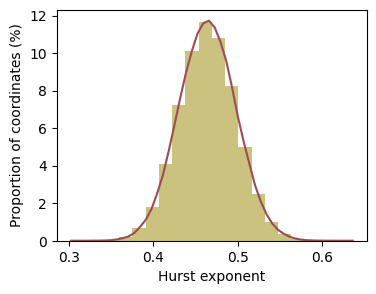

In [97]:
from scipy import stats

kde = stats.gaussian_kde(exponents)

xx = np.linspace(np.min(exponents) - 0.01, np.max(exponents) + 0.01, 50)

fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(exponents, density=True, bins=20, alpha=1.0, color='#CAC27E')
ax.plot(xx, kde(xx), color='#9D4C52')

ax.set_xlabel('Hurst exponent')
ax.set_ylabel('Proportion of coordinates (%)')

# ax.tick_params(axis='both', direction='in', top=True, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)

if not os.path.exists('figs'):
    os.mkdir('figs')
plt.savefig(os.path.join('figs', 'bulk_of_hurst_exponents.pdf'), format='pdf', bbox_inches='tight')

* Estimate Hausdorff dimension

In [10]:
from utils import fractal_dimension
dim_h = fractal_dimension(exponents)

print('fractal dimension: ', dim_h)

fractal dimension:  3.111933187718705
